GROUP DETAILS Mandatory
# Alphabetical order:
# Dube, Sanele - 1234567
# O Luthuli 22325286
# SN Madide 22314172
# NN Ndimande 22330918
# S Nombika 22312280
# QC Mtshali 22364740


DATASET & JUSTIFICATION

**Dataset**: Hospital Patient Records by *blueblushed* on Kaggle  
**Link**: https://www.kaggle.com/datasets/blueblushed/hospital-dataset-for-practice  

**Why it fits Task One (Healthcare Demand Prediction):**
- Multi-relational: supports splitting into Patients, Appointments, Conditions, Outcomes  
- Real hospital data—more realistic than synthetic alternatives  
- Captures demand drivers like patient demographics, treatment types, and outcomes


IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

LOADING DATASET

In [9]:
from google.colab import files
uploaded = files.upload()  # Upload your Kaggle CSVs extracted here

# E.g.:
patients_df = pd.read_csv("patients.csv")
appointments_df = pd.read_csv("appointments.csv")
treatments_df = pd.read_csv("treatments.csv")
billing_df = pd.read_csv("billing.csv")


Saving Hospital manangement-20250829T111627Z-1-001.zip to Hospital manangement-20250829T111627Z-1-001 (1).zip


DATA QUALITY CHECKS

In [10]:
for df, name in [(patients_df, "Patients"), (appointments_df, "Appointments"),
                 (treatments_df, "Treatments"), (billing_df, "Billing")]:
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Missing values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum(), "\n")


--- Patients ---
Shape: (50, 11)
Missing values:
 patient_id            0
first_name            0
last_name             0
gender                0
date_of_birth         0
contact_number        0
address               0
registration_date     0
insurance_provider    0
insurance_number      0
email                 0
dtype: int64
Duplicates: 0 

--- Appointments ---
Shape: (200, 7)
Missing values:
 appointment_id      0
patient_id          0
doctor_id           0
appointment_date    0
appointment_time    0
reason_for_visit    0
status              0
dtype: int64
Duplicates: 0 

--- Treatments ---
Shape: (200, 6)
Missing values:
 treatment_id      0
appointment_id    0
treatment_type    0
description       0
cost              0
treatment_date    0
dtype: int64
Duplicates: 0 

--- Billing ---
Shape: (200, 7)
Missing values:
 bill_id           0
patient_id        0
treatment_id      0
bill_date         0
amount            0
payment_method    0
payment_status    0
dtype: int64
Duplicates: 0 



BUILD MASTER DATASET

In [11]:
master_df = appointments_df.merge(patients_df, on="patient_id", how="left")
master_df = master_df.merge(treatments_df, on="appointment_id", how="left")
master_df = master_df.merge(billing_df, on="treatment_id", how="left")
print("Master dataset shape:", master_df.shape)


Master dataset shape: (200, 28)


In [19]:
print(master_df.columns.tolist())


['appointment_id', 'patient_id_x', 'doctor_id', 'appointment_date', 'appointment_time', 'reason_for_visit', 'status', 'first_name', 'last_name', 'gender', 'date_of_birth', 'contact_number', 'address', 'registration_date', 'insurance_provider', 'insurance_number', 'email', 'treatment_id', 'treatment_type', 'description', 'cost', 'treatment_date', 'bill_id', 'patient_id_y', 'bill_date', 'amount', 'payment_method', 'payment_status', 'appointment_month', 'appointment_day', 'appointment_weekday', 'is_weekend', 'age', 'age_group', 'has_private_insurance']


FEATURE ENGINEERING

In [20]:


# Ensure appointment_date is datetime
master_df["appointment_date"] = pd.to_datetime(master_df["appointment_date"], errors="coerce")

# --- Time-based features ---
master_df["appointment_month"] = master_df["appointment_date"].dt.month
master_df["appointment_day"] = master_df["appointment_date"].dt.day
master_df["appointment_weekday"] = master_df["appointment_date"].dt.dayofweek
master_df["is_weekend"] = master_df["appointment_weekday"].isin([5, 6]).astype(int)

# --- Age from date_of_birth ---
master_df["date_of_birth"] = pd.to_datetime(master_df["date_of_birth"], errors="coerce")
today = pd.to_datetime("today")
master_df["age"] = (today - master_df["date_of_birth"]).dt.days // 365

# --- Age groups ---
def age_group(age):
    if pd.isnull(age):
        return "Unknown"
    elif age < 18:
        return "Child"
    elif age < 35:
        return "Young Adult"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"

master_df["age_group"] = master_df["age"].apply(age_group)

# --- Insurance indicator (based on insurance_provider) ---
master_df["has_private_insurance"] = master_df["insurance_provider"].apply(
    lambda x: 0 if pd.isnull(x) or str(x).strip().lower() in ["public", "government"] else 1
)

# --- Appointment counts per patient (using patient_id_x) ---
master_df["appointments_per_patient"] = (
    master_df.groupby("patient_id_x")["appointment_id"].transform("count")
)

# Quick preview
print(master_df[[
    "appointment_date", "appointment_month", "appointment_day", "appointment_weekday",
    "is_weekend", "date_of_birth", "age", "age_group", "insurance_provider",
    "has_private_insurance", "appointments_per_patient"
]].head())


  appointment_date  appointment_month  appointment_day  appointment_weekday  \
0       2023-08-09                  8                9                    2   
1       2023-06-09                  6                9                    4   
2       2023-06-28                  6               28                    2   
3       2023-09-01                  9                1                    4   
4       2023-07-06                  7                6                    3   

   is_weekend date_of_birth  age age_group insurance_provider  \
0           0    1950-01-26   75    Senior       WellnessCorp   
1           0    1981-01-08   44     Adult       MedCare Plus   
2           0    1983-03-24   42     Adult        PulseSecure   
3           0    1966-08-14   59     Adult        HealthIndia   
4           0    1972-05-30   53     Adult        PulseSecure   

   has_private_insurance  appointments_per_patient  
0                      1                         3  
1                      1    

 DEFINING DEMAND TARGET

In [22]:
# --- 8. DEFINE DEMAND TARGET ---

# Use treatment_type as a proxy for specialization
demand_df = (
    master_df.groupby(["treatment_type", "appointment_month"])
    .size()
    .reset_index(name="appointment_count")
)

print(demand_df.head())


  treatment_type  appointment_month  appointment_count
0   Chemotherapy                  1                  4
1   Chemotherapy                  2                  3
2   Chemotherapy                  3                  5
3   Chemotherapy                  4                  6
4   Chemotherapy                  5                  6


VISUALIZATIONS

Bar chart: total monthly demand

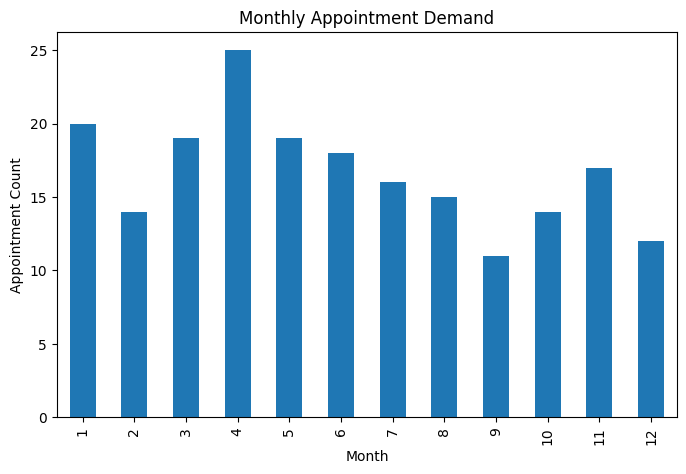

In [24]:
# Monthly Appointment Demand
plt.figure(figsize=(8,5))
demand_df.groupby("appointment_month")["appointment_count"].sum().plot(kind="bar")
plt.title("Monthly Appointment Demand")
plt.xlabel("Month")
plt.ylabel("Appointment Count")
plt.show()


Horizontal bar chart: which treatment types generate the most load

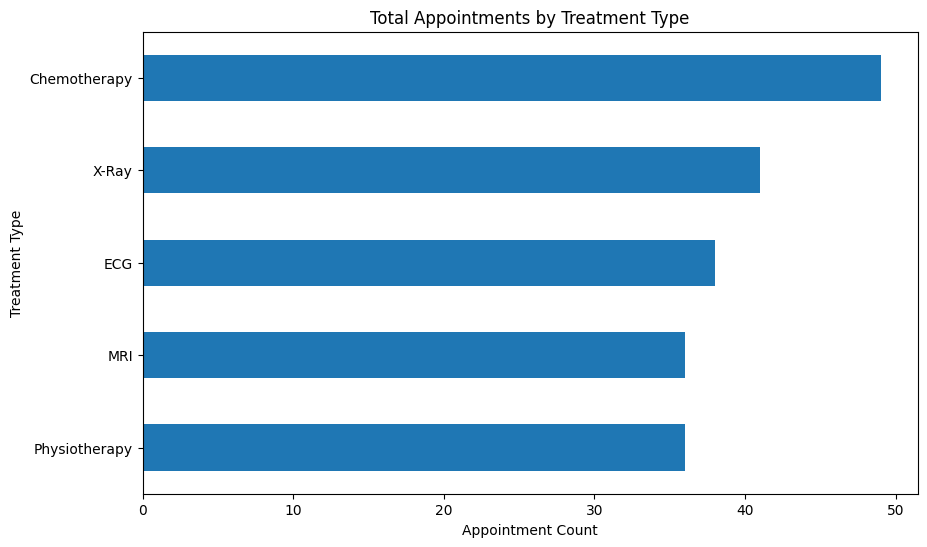

In [25]:
# Total Demand by Treatment Type
plt.figure(figsize=(10,6))
demand_df.groupby("treatment_type")["appointment_count"].sum().sort_values().plot(kind="barh")
plt.title("Total Appointments by Treatment Type")
plt.xlabel("Appointment Count")
plt.ylabel("Treatment Type")
plt.show()


Line plot: how each treatment type’s demand changes over months

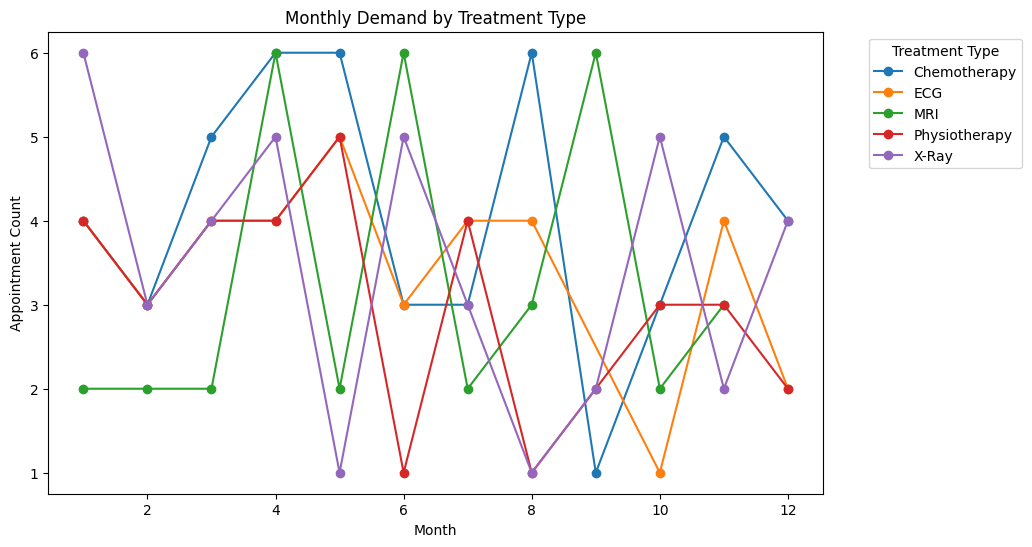

In [26]:
# --- 9.3 Monthly Demand by Treatment Type ---
plt.figure(figsize=(10,6))
for treatment in demand_df["treatment_type"].unique():
    subset = demand_df[demand_df["treatment_type"] == treatment]
    plt.plot(subset["appointment_month"], subset["appointment_count"], marker="o", label=treatment)

plt.title("Monthly Demand by Treatment Type")
plt.xlabel("Month")
plt.ylabel("Appointment Count")
plt.legend(title="Treatment Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


Demographic bar chart: demand by age group

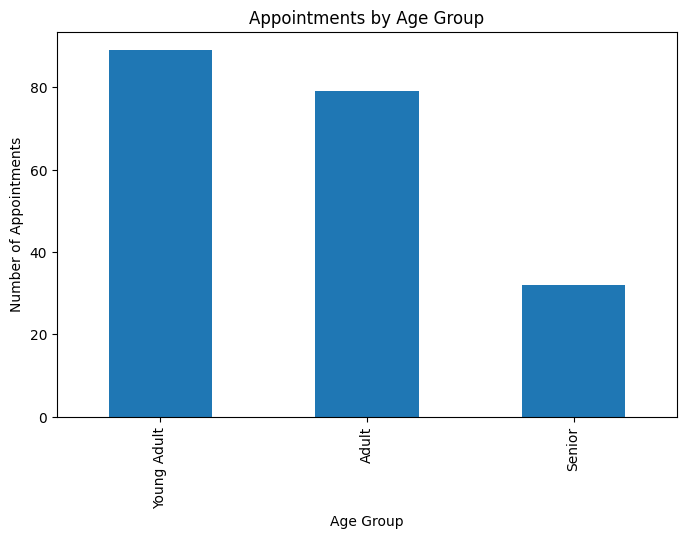

In [27]:
# --- 9.4 Appointments by Age Group ---
plt.figure(figsize=(8,5))
master_df["age_group"].value_counts().plot(kind="bar")
plt.title("Appointments by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Appointments")
plt.show()


Operational insight: weekday vs weekend appointments

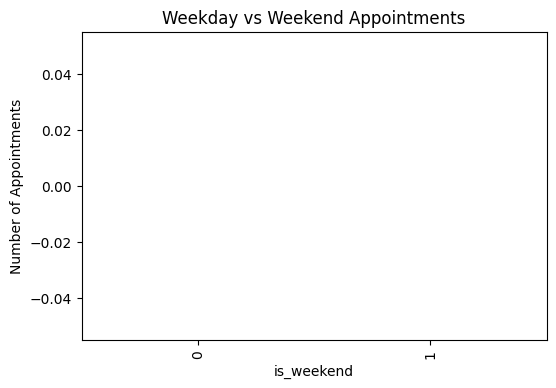

In [28]:
# Weekday vs Weekend Demand
plt.figure(figsize=(6,4))
master_df["is_weekend"].value_counts().map({0:"Weekday",1:"Weekend"}).plot(kind="bar")
plt.title("Weekday vs Weekend Appointments")
plt.ylabel("Number of Appointments")
plt.show()


MODEL TRAINING & EVALUATION

In [35]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [39]:
# Features and target
X = demand_df[["appointment_month"]]
y = demand_df["appointment_count"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Baseline": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# Train, evaluate, and store results
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5   # manual square root
    r2 = r2_score(y_test, preds)
    cv = cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    results.append([name, mae, rmse, r2, cv])

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²", "CV R²"])
results_df


,Model,MAE,RMSE,R²,CV R²
0,Baseline,0.942029,1.241480,-0.180549,-0.080071
1,Linear Regression,0.780420,1.113915,0.049596,-0.058911
2,Random Forest,1.244088,1.577188,-0.905336,-0.368095
3,Gradient Boosting,1.367982,1.743789,-1.329123,-0.398919
